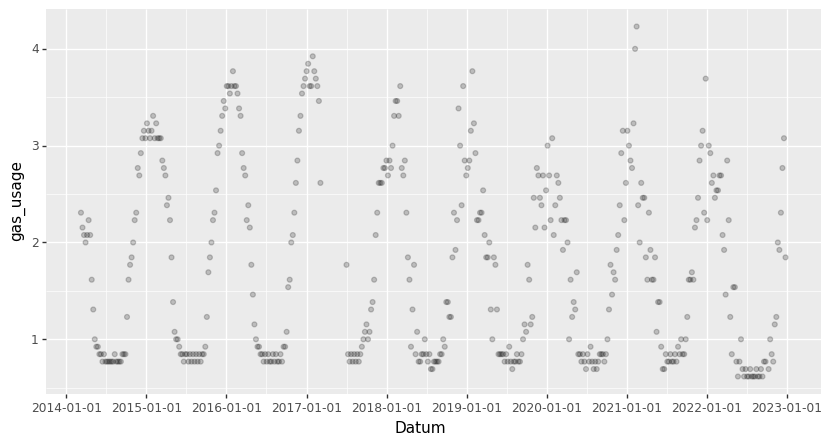

<ggplot: (8743257626061)>

In [79]:
import pandas as pd
from local_functions import *
from plotnine import *
import calendar

energy_usage = pd.read_excel('data/usage_anonymized.xlsx', index_col=[0])
temperature = read_knmi('data/knmi_weather.txt')

gas_usage = (
    energy_usage['gas_usage']
      .resample('W').sum().reset_index()
      .merge(temperature.resample('W').mean().reset_index(), left_on='Datum', right_on='date')
)
gas_usage["month_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%B'), categories=calendar.month_name[1:]) # Settings categories here to force the correct order on the axis
gas_usage["year_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%Y'))
gas_usage['post_install'] = gas_usage['Datum'] > 'May 2022'



# Eliminate weeks that do not have the full 7 days, because we sum the data over the days
# and for those non-complete weeks this would underestimate the gas_usage, thus skewing the results
non_complete_weeks = (
    energy_usage['gas_usage']
      .resample('W').count() != 7
)
non_complete_dates = non_complete_weeks.loc[non_complete_weeks].index.values
gas_usage = (
  gas_usage.loc[~gas_usage['Datum'].isin(non_complete_dates)]
     .reset_index().drop(columns='index') # This is sadly needed as plotnine will throw an error without it. Might be connected to the new index not being contiguous anymore
)

(
    ggplot(gas_usage, aes(x='Datum', y='gas_usage')) 
      + geom_point(alpha=0.2)
      # + geom_line(data=gas_usage['gas_usage'].resample('W').mean().reset_index())
      + theme(figure_size=(10,5))
)

# Monthly total gas usage versus temperature

/opt/conda/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 50 rows containing missing values.


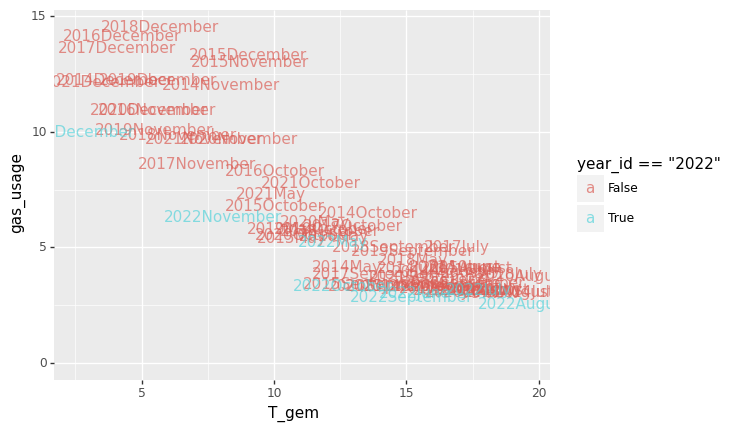

<ggplot: (8743257469922)>

In [80]:
sept_usages = pd.DataFrame({'gas_usage': gas_usage.query('month_id in ["May", "June", "July", "August", "September", "October", "November", "December"]').groupby(['year_id', 'month_id'])['gas_usage'].sum(),
                            'T_gem':     gas_usage.query('month_id in ["May", "June", "July", "August", "September", "October", "November", "December"]').groupby(['year_id', 'month_id'])['T_gem'].mean()}).reset_index()
sept_usages['year_month'] = sept_usages['year_id'].str.cat(sept_usages['month_id'])
(
    ggplot(sept_usages, aes(x='T_gem', y='gas_usage')) + geom_text(aes(label='year_month', color='year_id == "2022"'), alpha = 0.7)
)

What really strikes me is how low the gas usage is for september 2022 compared to other months that have the same average temperature. It is offcourse not possible to ascribe this to the boiler uniquely as we also lowered the theormostat. But the added value in augustus does provide some assurance that the boiler has a role to play. 

# Boxplot of temperature (binned) versus gas usage
This is a mash-up between the month-gas usage boxplot and the scatterplot. This very clearly shows that for a given temperature range the post install ranges are very low. 

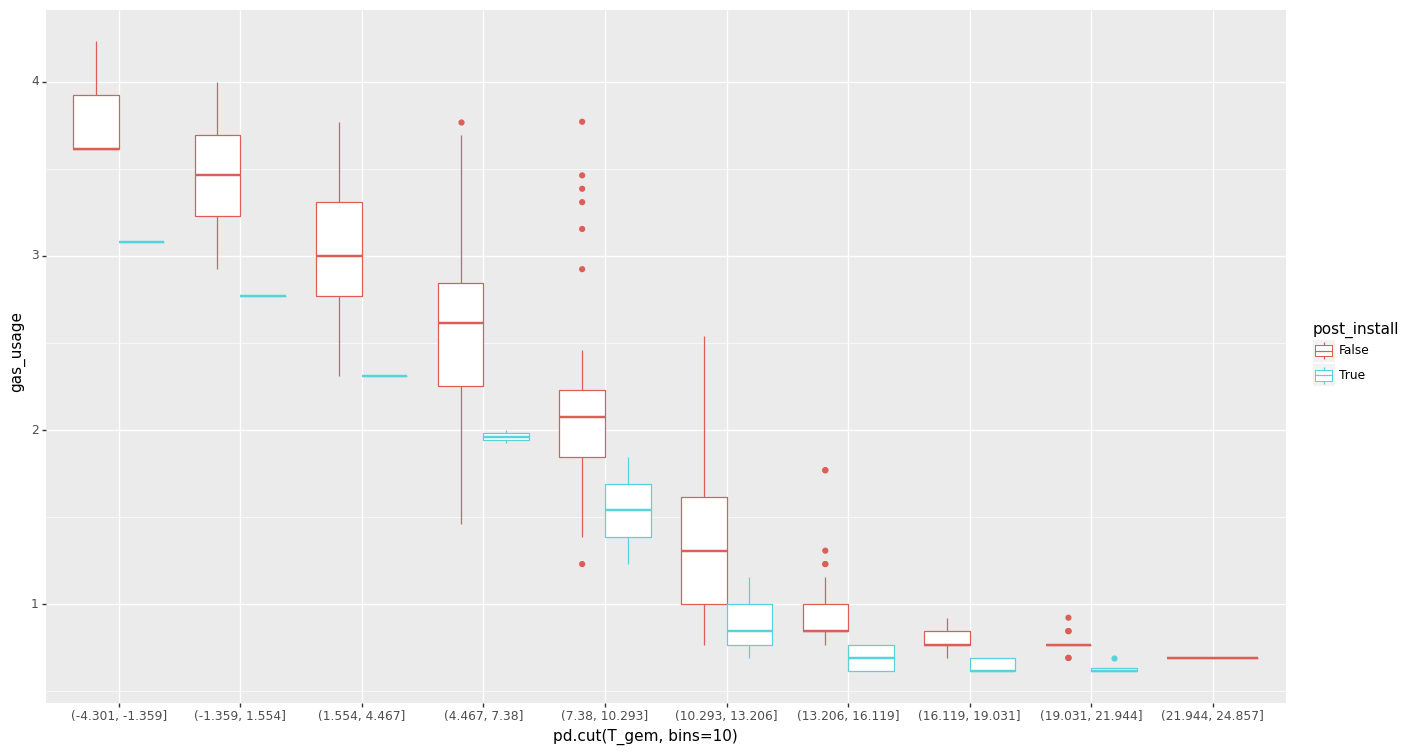

<ggplot: (8743252815351)>

In [81]:
(
    ggplot(gas_usage) 
      + geom_boxplot(aes(x = 'pd.cut(T_gem, bins=10)', y = 'gas_usage', color='post_install'), position='dodge') 
      + theme(figure_size=(16,9))
)

# Year-on-year trend within a given temperature bracket
We want to see the yearly trend within a temperature bracket. Because we split the data per temperature bracket and year we cannot use too meany bins as we don't have that much post_install data to divvy up across the many resulting bins. This figure nicely shows a consistent downward trend post installation of the boiler. 

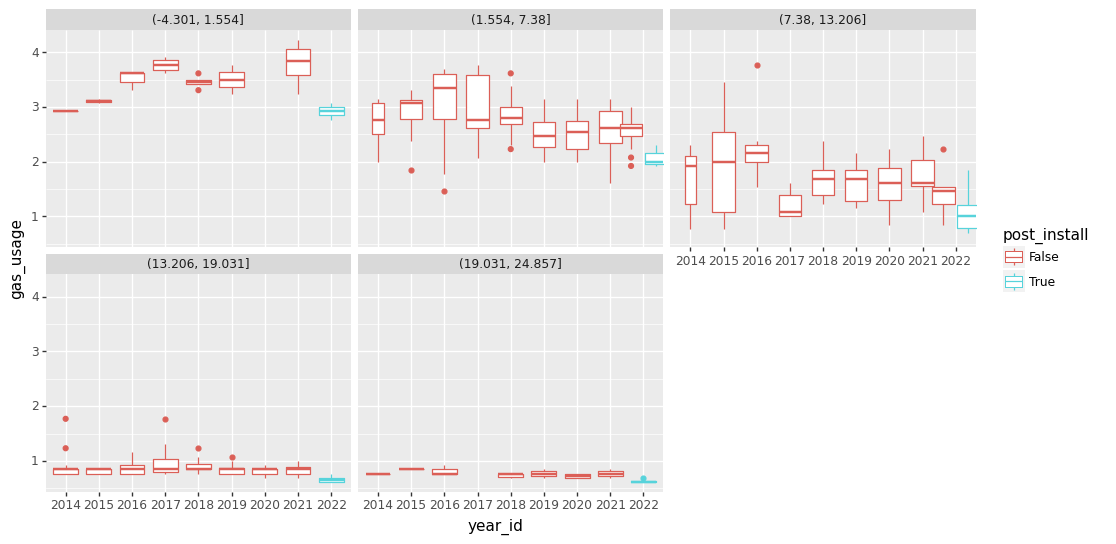

<ggplot: (8743257440260)>

In [82]:
gas_usage['T_gem_cut'] = pd.cut(gas_usage['T_gem'], bins=5)
# Note that we use just 5 bins here. That is to prevent that a timeline is broken because for a 

(
    ggplot(gas_usage) 
      + geom_boxplot(aes('year_id', 'gas_usage', color='post_install')) 
      + facet_wrap('~ T_gem_cut', nrow=2) 
      + theme(figure_size=(12,6))
      # + scale_y_continuous(trans='log')
)